# Create a circuit on a Grid

To build Quantum Algorithms using Cirq, one starts by building an appropriate circuit.
Circuits in cirq are represented by a Circuit object

In [44]:
import cirq, sympy, random

from cirq.contrib.svg import SVGCircuit

%matplotlib inline

In [30]:
# define the length of the grid.
length = 3
# define qubits on the grid.
qubits = [cirq.GridQubit(i, j) for i in range(length) for j in range(length)]
print(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2)]


In [32]:
# Make an empty circuit
circuit = cirq.Circuit()
print(circuit)

In [38]:
'''
Now, we are using the qubits we defined earlier and apply either a Hadarmard gate, 
if their row+column index is even, or a X gate if their row+column index is odd.
'''
# More about gates -> https://github.com/quantumlib/Cirq/blob/master/cirq/ops/common_gates.py
circuit.append(cirq.H(q) for q in qubits if (q.row + q.col) % 2 == 0)
circuit.append(cirq.X(q) for q in qubits if (q.row + q.col) % 2 == 1)
#print(circuit)

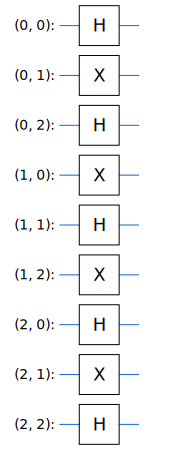

In [37]:
# Making a GUI of the circuit
SVGCircuit(circuit)

In [40]:
'''
One thing to notice about the above circuit is that the gates from both the append instructions
appear on the same vertical line. Gates appearing on the same vertical line constitue a Moment.

We can modify this by changing the InsertStrategy() of the append method().
'''
circuit = cirq.Circuit()
circuit.append([cirq.H(q) for q in qubits if (q.row + q.col) % 2 == 0],
               strategy=cirq.InsertStrategy.EARLIEST)
circuit.append([cirq.X(q) for q in qubits if (q.row + q.col) % 2 == 1],
               strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
#print(circuit)

This circuit has now has staggered gates created by two Moments.

In [41]:
for i, m in enumerate(circuit):
    print('Moment {}: {}'.format(i, m))

Moment 0: H((0, 0)) and H((0, 2)) and H((1, 1)) and H((2, 0)) and H((2, 2))
Moment 1: X((0, 1)) and X((1, 0)) and X((1, 2)) and X((2, 1))


# Creating the Ansatz

In [49]:
def rot_x_layer(length, half_turns):
    """Yields X rotations by half_turns on a square grid of given length."""
    rot = cirq.XPowGate(exponent=half_turns)
    for i in range(length):
        for j in range(length):
            yield rot(cirq.GridQubit(i, j))

'''
Another important concept here is that the rotation gate is specified in “half turns”. 
For a rotation about X this is the gate cos(half_turns * pi) I + i sin(half_turns * pi) X.
'''
circuit = cirq.Circuit()
circuit.append(rot_x_layer(2, 0.1))
print(circuit)

(0, 0): ───X^0.1───

(0, 1): ───X^0.1───

(1, 0): ───X^0.1───

(1, 1): ───X^0.1───


In [58]:
# Make a 2d array with elements either +1 or -1 selected at random
def rand2d(rows, cols):
    return [[random.choice([+1, -1]) for _ in range(cols)] for _ in range(rows)] # Neat way to make a 2d array

In [46]:
# Code for generating random problem instances
def random_instance(length):
    # transverse field terms
    h = rand2d(length, length)
    # links within a row
    jr = rand2d(length - 1, length)
    # links within a column
    jc = rand2d(length, length - 1)
    return (h, jr, jc)

h, jr, jc = random_instance(3)
print('transverse fields: {}'.format(h))
print('row j fields: {}'.format(jr))
print('column j fields: {}'.format(jc))

transverse fields: [[-1, 1, 1], [1, -1, -1], [1, -1, 1]]
row j fields: [[-1, -1, 1], [1, -1, -1]]
column j fields: [[-1, 1], [1, -1], [1, 1]]


In [59]:
def rot_z_layer(h, half_turns):
    """Yields Z rotations by half_turns conditioned on the field h."""
    gate = cirq.ZPowGate(exponent=half_turns)
    for i, h_row in enumerate(h):
        for j, h_ij in enumerate(h_row):
            if h_ij == 1:
                yield gate(cirq.GridQubit(i, j))

In [60]:
     

def rot_11_layer(jr, jc, half_turns):
    """Yields rotations about |11> conditioned on the jr and jc fields."""
    gate = cirq.CZPowGate(exponent=half_turns)    
    for i, jr_row in enumerate(jr):
        for j, jr_ij in enumerate(jr_row):
            if jr_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i + 1, j))
            yield gate(cirq.GridQubit(i, j),
                       cirq.GridQubit(i + 1, j))
            if jr_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i + 1, j))

    for i, jc_row in enumerate(jc):
        for j, jc_ij in enumerate(jc_row):
            if jc_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i, j + 1))
            yield gate(cirq.GridQubit(i, j),
                       cirq.GridQubit(i, j + 1))
            if jc_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i, j + 1))

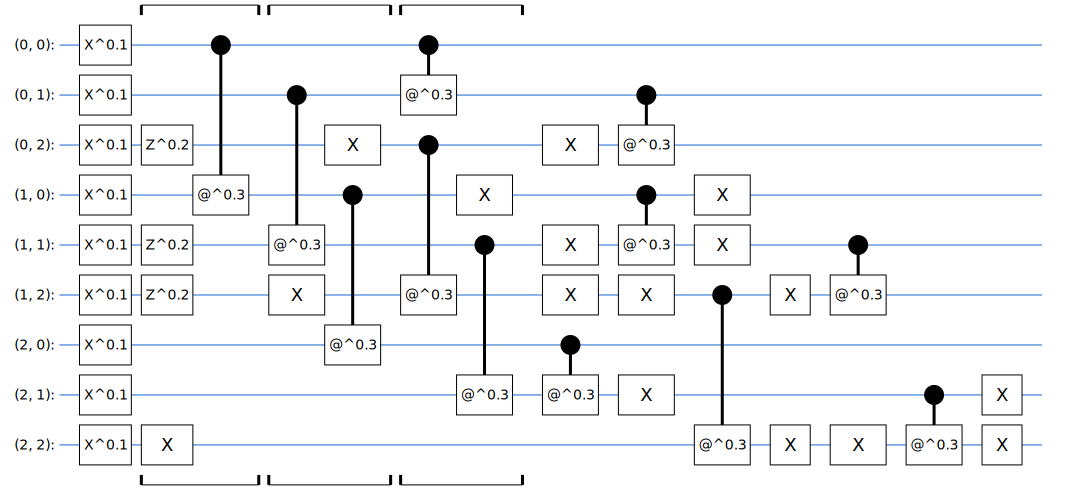

In [62]:
def one_step(h, jr, jc, x_half_turns, h_half_turns, j_half_turns):
    length = len(h)
    yield rot_x_layer(length, x_half_turns)
    yield rot_z_layer(h, h_half_turns)
    yield rot_11_layer(jr, jc, j_half_turns)

h, jr, jc = random_instance(3)

circuit = cirq.Circuit()    
circuit.append(one_step(h, jr, jc, 0.1, 0.2, 0.3),
               strategy=cirq.InsertStrategy.EARLIEST)
#print(circuit)
SVGCircuit(circuit)

# Simulation